#  ***Прогнозирование заказов такси***

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

Компания, предоставляющая услуги такси, собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Наша задача - построить модель для такого предсказания.

Обязательные условия по ТЗ:
 - Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.
 - Выполнить ресемплирование данных по одному часу.
 - Проанализировать данные.
 - Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
 - Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Загрузка и подготовка данных

In [1]:
try:
    from lightgbm import LGBMRegressor
except:
    !pip install 'lightgbm[scikit-learn]' -q
    from lightgbm import LGBMRegressor

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
sns.set()
RANDOM_STATE = 666
TEST_SIZE = 0.1
ALPHA = 0.05
np.random.seed(RANDOM_STATE)
PATH = "/datasets/taxi.csv"
URL = "https://.../datasets/taxi.csv"

Загрузим данные, приведя временной признак к типу данных `datetime` и преобразовав его в индекс.

In [ ]:
try:
    data = pd.read_csv(PATH, index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv(URL, index_col=[0], parse_dates=[0])

## Анализ

In [5]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные соответствуют описанию, пропущенных значений нет. Отсортируем данные по индексу.

In [6]:
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


У нас имеются данные за период с 2018-03-01 по 2018-08-31. Убедимся, что во временном ряде нет пропущенных часов.

In [7]:
deltas = pd.Series(data.index).diff()[1:]

gaps = deltas[deltas > timedelta(hours=1)]
print(f'Во временном ряде имеется {len(gaps)} случаев пропущенных часов.')

Во временном ряде имеется 0 случаев пропущенных часов.


Выполним ресемплирование данных по одному часу.

In [8]:
data = data.resample('1H').sum()

In [9]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Итак, у нас 4416 наблюдений за каждый час с 2018-03-01 по 2018-08-31. Посмотрим график зависимости количества заказов рт времени.

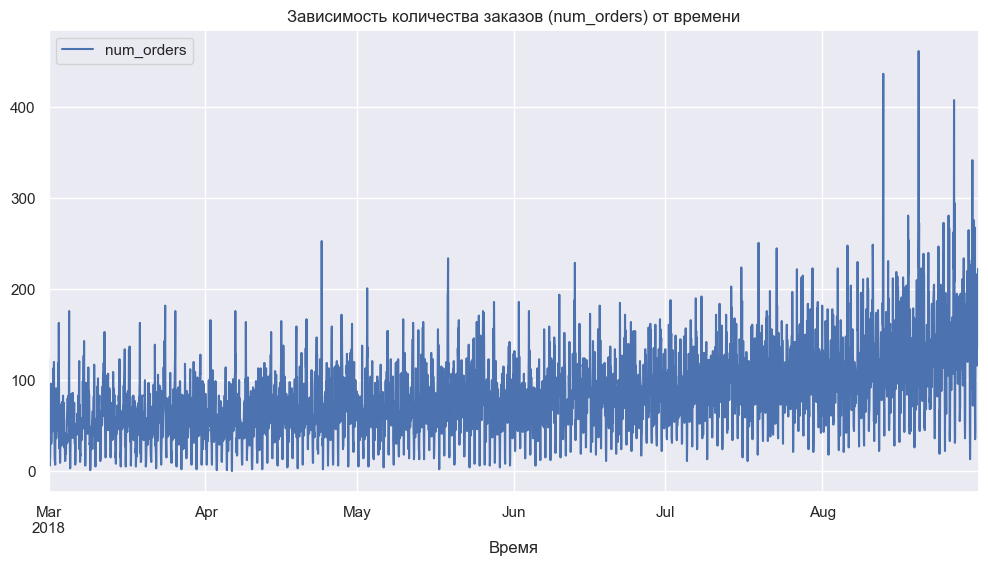

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Зависимость количества заказов (num_orders) от времени');
data.plot(ax=plt.gca(), xlabel='Время');

Во временном ряду можно заметить тренд на возростание количества заказов и некие сезонные колебания. Рассмотрим срез данных за август.

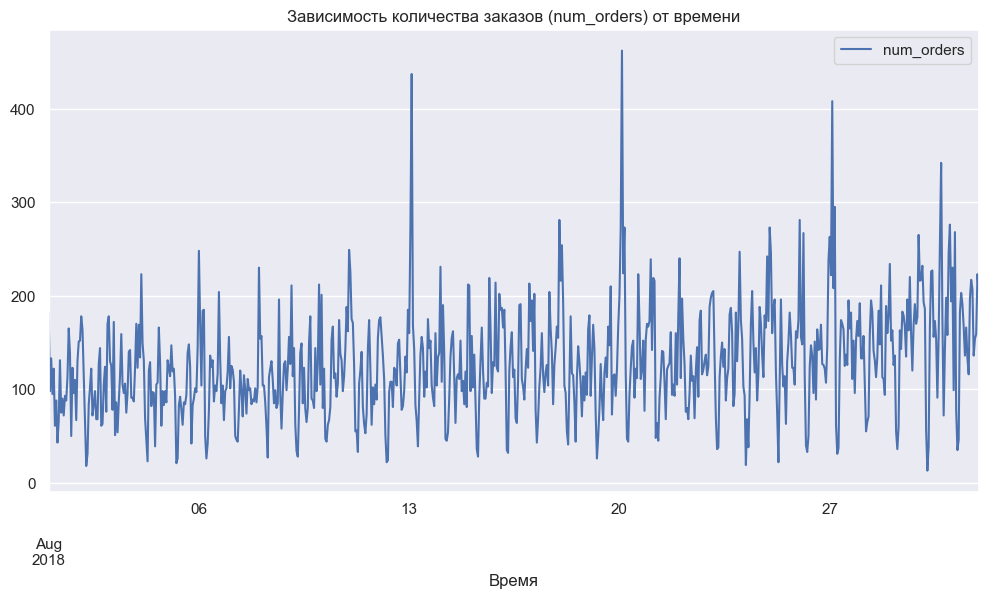

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Зависимость количества заказов (num_orders) от времени');
data['2018-08-01':'2018-08-31'].plot(ax=plt.gca(), xlabel='Время');

В масштабе месяца можно заметить слабую недельную и ярко выраженную суточную сезонности. С помощью библиотеки `statsmodels` разложим временной ряд на три составляющие: тренд, сезонность и остаток.

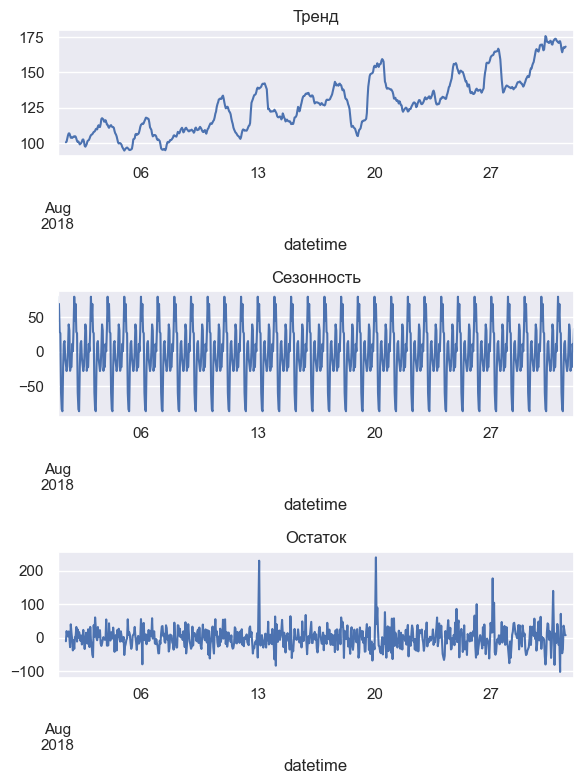

In [12]:
decomposed = seasonal_decompose(data['2018-08-01':'2018-08-31'])

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Статистический инструмент выделил волнообразный тренд на повышение и четкую суточную сезонность. Также заметны пики количества заказов по определенным дням недели (с промежутком в 7 дней).

Посмотрим как изменяется количество заказов в течении суток. Для примера построим график количества заказов 1 и 2 Августа 2018 года.

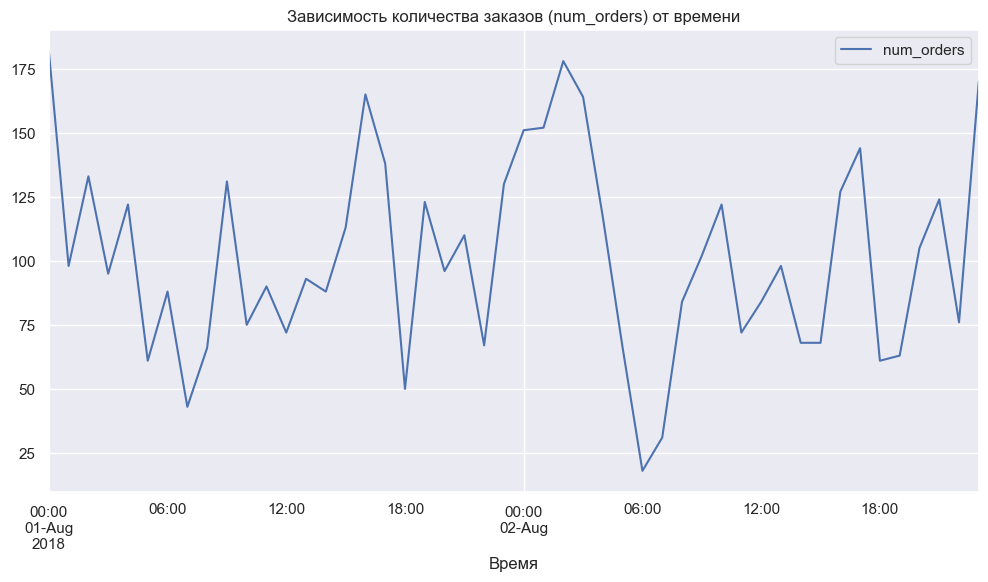

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Зависимость количества заказов (num_orders) от времени');
data['2018-08-01 00:00:00':'2018-08-02 23:00:00'].plot(ax=plt.gca(), xlabel='Время');

Выведем столбчатые графики среднего количества заказов для разных часов, дней недели и месяцев за весь период наблюдений.

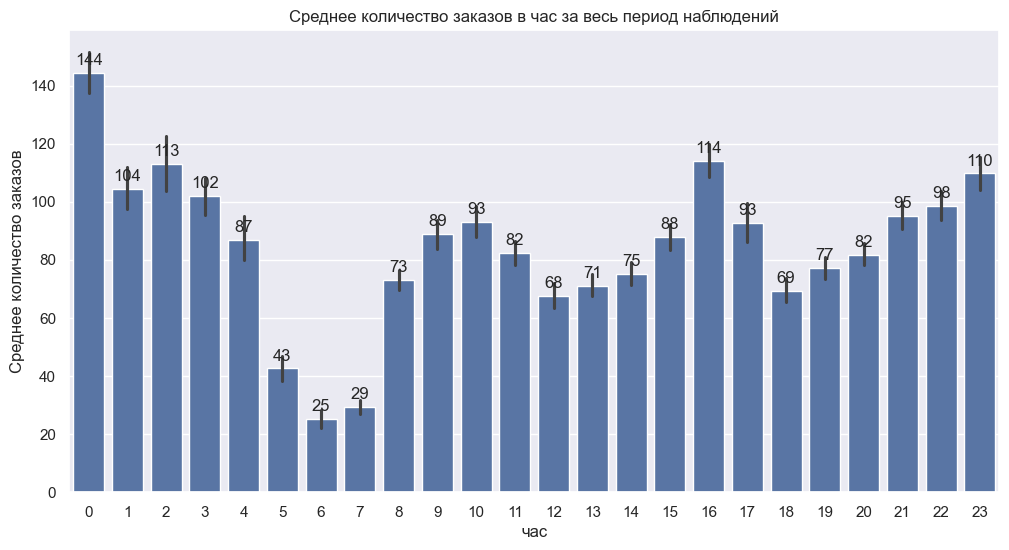

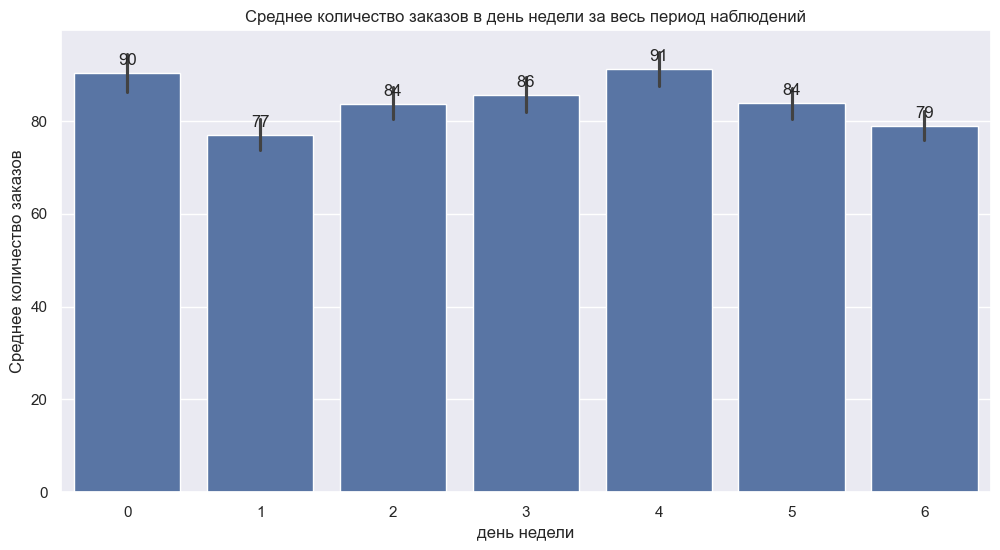

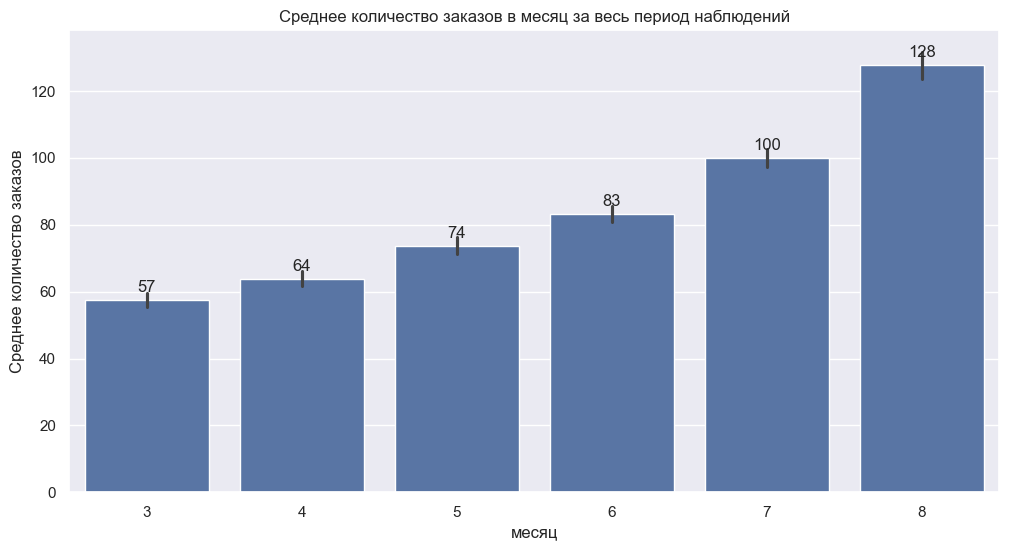

In [14]:
time_units = ['hour', 'dayofweek', 'month']
time_unit_names = ['час', 'день недели', 'месяц']
for i, time_unit in enumerate(time_units):
    fig, ax = plt.subplots(figsize=(12, 6));
    splot = sns.barplot( x=eval('data.index.' + time_unit),
                         y=data['num_orders']);
    for p in splot.patches: 
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points')
    plt.title(f'Среднее количество заказов в {time_unit_names[i]} за весь период наблюдений');
    plt.ylabel(f'Среднее количество заказов')
    plt.xlabel(f'{time_unit_names[i]}')
    plt.show()

Мы видим, что распределение среднего количества заказов по часам/дням недели/месяцам подтверждает замеченные ранее тренд и сезонности и сигнализирует о значимости признаков, созданных на основе соответсвующих интервалов времени.

Исходя из наблюдаемой картины, представляется разумным выделить следующие календарные признаки: день недели (чтобы учесть недельную сезонность) и день и месяц (чтобы долгосрочный учесть тренд). Чтобы принять во внимание суточную сезонность, создадим некоторое количество "отстающих признаков" и признак со скользящим средним.

## Обучение

Напишем функцию для создания новых признаков.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

Создадим предварительные обучающую и тестовые выборки.

In [16]:
train, test = train_test_split(data, shuffle=False, test_size=TEST_SIZE)
train.shape, test.shape

((3974, 1), (442, 1))

Теперь создадим модель линейной регрессии и подберем с ее помощью лучшее сочетание количества "отстающих" признаков и величину окна скользящего среднего на тренировочной выборке, разделенной на тренировочную и валидационную подвыборки.

В цикле подберем лучший набор признаков по метрике *RMSE*.

In [17]:
max_max_lag = 24            # максимальное количество "отстающих" признаков
max_rolling_mean_size = 10  # максимальная величина окна скользящего среднего

best_params = {'max_lag': 1, 'rolling_mean_size': 2}
best_rmse = 1000000

for max_lag in range(1, max_max_lag + 1):
    for rolling_mean_size in range(2, max_rolling_mean_size + 1):
        # создаем датафрейм с набором признаков
        df = make_features(data, max_lag, rolling_mean_size)
        
        # создадим тренировочную и валидационную подвыборки для модели линейной регрессии
        train_lr, valid_lr = train_test_split(df, shuffle=False, test_size=TEST_SIZE)
        train_lr = train_lr.dropna()
        X_train_lr = train_lr.drop('num_orders', axis=1)
        y_train_lr = train_lr['num_orders']
        X_valid_lr = valid_lr.drop('num_orders', axis=1)
        y_valid_lr = valid_lr['num_orders']
        
        # обучим модель и посчитаем метрику на валидационной подвыборке
        scaler = StandardScaler()
        model_lr = LinearRegression().fit(scaler.fit_transform(X_train_lr), y_train_lr)
        rmse = sqrt(mean_squared_error(y_valid_lr, model_lr.predict(scaler.transform(X_valid_lr))))
        print(f'max_lag: [{max_lag}], rolling_mean_size: [{rolling_mean_size}], rmse: [{rmse}]')
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params['max_lag'] = max_lag
            best_params['rolling_mean_size'] = rolling_mean_size

max_lag: [1], rolling_mean_size: [2], rmse: [52.76947058069251]
max_lag: [1], rolling_mean_size: [3], rmse: [52.858453672663956]
max_lag: [1], rolling_mean_size: [4], rmse: [52.90586105514352]
max_lag: [1], rolling_mean_size: [5], rmse: [53.02745879232516]
max_lag: [1], rolling_mean_size: [6], rmse: [53.324125379325444]
max_lag: [1], rolling_mean_size: [7], rmse: [53.411057088078245]
max_lag: [1], rolling_mean_size: [8], rmse: [53.46184624243687]
max_lag: [1], rolling_mean_size: [9], rmse: [53.799033432118854]
max_lag: [1], rolling_mean_size: [10], rmse: [53.82366435704729]
max_lag: [2], rolling_mean_size: [2], rmse: [52.76947058069252]
max_lag: [2], rolling_mean_size: [3], rmse: [52.45420941511786]
max_lag: [2], rolling_mean_size: [4], rmse: [52.60465033162616]
max_lag: [2], rolling_mean_size: [5], rmse: [52.87816032868664]
max_lag: [2], rolling_mean_size: [6], rmse: [53.331892583170934]
max_lag: [2], rolling_mean_size: [7], rmse: [53.47577412844993]
max_lag: [2], rolling_mean_size: [

In [18]:
print(f'Лучшая RMSE на валидационной выборке: {best_rmse:.4f}')
print(f'Лучший набор признаков: {best_params}')

Лучшая RMSE на валидационной выборке: 45.5259
Лучший набор признаков: {'max_lag': 24, 'rolling_mean_size': 2}


Далее используем полученную схему создания признаков для обучения более сложных моделей в пайплайне. Сначала подготовим обучающую и тестовые выборки, аналогично тому, как мы делали при подборе признаков.

In [19]:
# подготовим признаки
data = make_features(data, best_params['max_lag'], best_params['rolling_mean_size'])

# подготовим выборки
train, test = train_test_split(data, shuffle=False, test_size=TEST_SIZE)
train.shape, test.shape

((3974, 30), (442, 30))

In [20]:
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

В пайплайне создадим модели трех типов: линейной регрессии, случайного леса и градиентного бустинга (`sklearn.linear_model.LinearRegression`, `lightgbm.LGBMRegressor` и `sklearn.ensemble.RandomForestRegressor`) с подбором гиперпараметров моделей с помощью инструмента `sklearn.model_selection.RandomizedSearchCV` с кроссвалидацией. Масштабируем признаки через `sklearn.preprocessing.StandardScaler`.

In [21]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('num', StandardScaler(), X_train.columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [

# словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
    },

# словарь для модели RandomForestRegressor()
    {
        'models': [RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 130],
        'models__min_samples_split': [3, 4],
    },  

# словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1)],
        'models__num_leaves': [20, 30],
        'models__learning_rate': [0.03, 0.05],
        'models__n_estimators': [100, 200]
    }      
]

tscv = TimeSeriesSplit(n_splits=3)

random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    verbose=-1,
    n_iter=13,
    n_jobs=-1,
)

Выполним поиск лучшей модели и гиперпараметров.

In [33]:
%%time
random_search.fit(X_train, y_train);

CPU times: total: 1.77 s
Wall time: 13.3 s


Выведем лучшую модель, гиперпараметры и среднее значение ее *RMSE* на кроссвалидации.

In [34]:
model = random_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
display(model)
display(random_search.best_params_)
print ('Метрика лучшей модели по результатам кроссвалидации на тренировочной выборке:',
       -1 * random_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean'],
      dtype='object'))])),
                ('models',
                 LGBMRegressor(learning_rate=0.05, n_estimators=200,
                               num_leaves=20, random_state=666,
                               verbosity=-1))])


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['year', 'month', 'day', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean'],
      dtype='object'))])),
                ('models',
                 LGBMRegressor(learning_rate=0.05, n_estimators=200,
                               num_leaves=20, random_state=666,
                               verbosity=-1))])

{'models__num_leaves': 20,
 'models__n_estimators': 200,
 'models__learning_rate': 0.05,
 'models': LGBMRegressor(learning_rate=0.05, n_estimators=200, num_leaves=20,
               random_state=666, verbosity=-1)}

Метрика лучшей модели по результатам кроссвалидации на тренировочной выборке: 27.06063527089088


Сравним результаты трех моделей на кроссвалидации.

In [35]:
results = pd.DataFrame(random_search.cv_results_)
results['param_models'] = results['param_models'].apply(lambda x: str(x))
pd.set_option('display.max_colwidth', None)

In [36]:
(results[['rank_test_score', 'mean_test_score', 'param_models', 'params']]
        .sort_values(by=['rank_test_score'])
        .groupby('param_models', sort=False)
        .head(1))

,rank_test_score,mean_test_score,param_models,params
11,1,-27.060635,"LGBMRegressor(learning_rate=0.05, n_estimators=200, num_leaves=20,\n random_state=666, verbosity=-1)","{'models__num_leaves': 20, 'models__n_estimators': 200, 'models__learning_rate': 0.05, 'models': LGBMRegressor(learning_rate=0.05, n_estimators=200, num_leaves=20, random_state=666, verbosity=-1)}"
0,7,-27.532345,LinearRegression(),{'models': LinearRegression()}
4,8,-27.547499,"RandomForestRegressor(n_jobs=-1, random_state=666)","{'models__n_estimators': 130, 'models__min_samples_split': 4, 'models': RandomForestRegressor(n_jobs=-1, random_state=666)}"


Таким образом, по результатам кроссвалидации лучшей моделью оказалась модель градиентного бустинга с гиперпараметрами 'models__num_leaves': 20, 'models__n_estimators': 200, 'models__learning_rate': 0.05. Впрочем, две другие модели не намного отстали.

## Тестирование

Сделаем предсказания и посчитаем *RMSE* на тестовой выборке для лучшей модели.

In [37]:
y_test_pred = random_search.predict(X_test)
print(f'Метрика RMSE на тестовой выборке:'
      f' {sqrt(mean_squared_error(y_test, y_test_pred)):.4f}')

Метрика RMSE на тестовой выборке: 41.1618


Выведем график предсказаний наряду с графиком истинных значений.

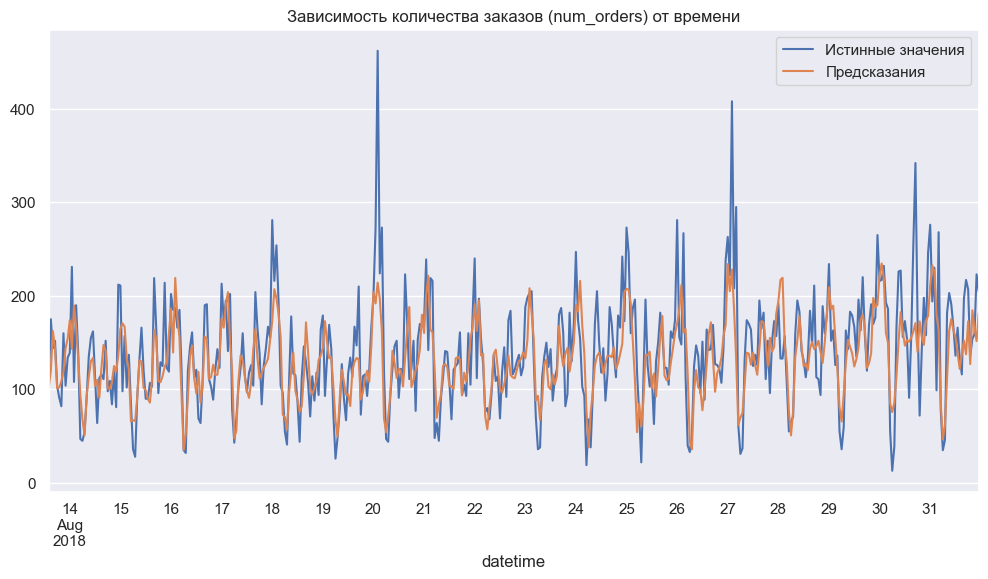

In [38]:
test_results = pd.DataFrame({'Истинные значения': y_test, 'Предсказания': y_test_pred})

fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Зависимость количества заказов (num_orders) от времени')
test_results['Истинные значения'].plot(ax=plt.gca(), legend='Истинные значения');
test_results['Предсказания'].plot(ax=plt.gca(), legend='Предсказания');
plt.show()


Результат модели удовлетворяет условиям ТЗ по метрике. Заметим, что на тестовой выборке значения метрики заметно хуже, чем на кроссвалидации, что говорит о некотором переобучении. Это ожидаемо, более свежие данные (а именно такие содержатся в тестовой выборке) могут содержать новые, незнакомые для модели тенденции. В связи с этим, модель нуждается в периодическом обучении на поступающих новых данных.

**Итак, мы построили модель градиентного бустинга, которая удовлетворяет всем условиям ТЗ и может быть использована заказчиком для прогнозирования количества заказов такси на следующий час. Для более точных прогнозов модель потребует периодического обучения на новых данных.**